<a href="https://colab.research.google.com/github/ramonsouzarss/dio/blob/main/DIO_Rede_Neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Rede de Deep Learning
##Para reconhecer dígitos
#####Foi aplicado o modelo [InceptionV3](https://keras.io/api/applications/inceptionv3/)


In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [2]:
transform = transforms.ToTensor() # Conversão de imagem para tensor

# Carrega a parte de treino do dataset
trainset = datasets.MNIST('./MNIST_data/', download=True,
                          train=True, transform=transform)
# Cria um buffer para pegar os dados por partes
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Carrega a parte de validação do dataset
valset = datasets.MNIST('./MNIST_data/', download=True,
                          train=False, transform=transform)
# Cria um buffer para pegar os dados por partes
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

In [3]:
class Modelo(nn.Module):

  def __init__(self):
    super(Modelo, self).__init__()
    self.linear1 = nn.Linear(28*28, 128) # Camada de entrada
    self.linear2 = nn.Linear(128, 64) # Camada interna 1
    self.linear3 = nn.Linear(64, 10) # Camada interna 2
    ''' Não é necessário definir a camada de saída pois é só pegar o output da
    camada interna 2 '''

  def call(self, X):
    X = F.relu(self.linear1(X)) # F Ativação da camada de entrada para interna 1
    X = F.relu(self.linear2(X)) # F Ativação da camada interna 1 para interna 2
    X = self.linear3(X) # Ativação da camada interna 2 para camada de saída
    return F.log_softmax(X, dim=1) # Dados utilizados para calcular a perda

In [4]:
def treino(modelo, trainloader, device):

  otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5)
  inicio = time()

  criterio = nn.NLLLoss()
  EPOCHS = 10
  modelo.train()

  for epoch in range(EPOCHS):
    perda_acumulada = 0

    for images, labels in trainloader:

      images = images.view(images.shape[0], -1)
      otimizador.zero_grad()

      output = modelo(images.to(device))
      perda_instantanea = criterio(output, labels.to(device))

      perda_instantanea.backward()

      otimizador.step()

      perda_acumulada += perda_acumulada.item()

    else:
      print("Epoch {} - Perda resultante: {}".format(epoch+1, perda_acumulada/
                                                     len(trainloader)))
  print("\nTempo de treino (min) =",(time()-inicio)/60)

In [5]:
def validacao(modelo, valloader, device):
  conta_corretas, conta_todas = 0, 0
  for images,labels in valloader:
    for i in range(len(labels)):
      img = images[i].view(1, 784)

      with torch.no_grad():
        logps = modelo(img.to(device))

      ps = torch.exp(logps)
      probab = list(ps.cpu().numpy()[0])
      label_pred = probab.index(max(probab))
      label_certa = labels.numpy()[i]
      if(label_certa == label_pred):
        conta_corretas += 1
      conta_todas += 1
  print("Total de imagens testadas =", conta_todas)
  print("\nPrecisão do modelo = {}%".format(conta_corretas*100/conta_todas))

In [6]:
modelo = Modelo()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)

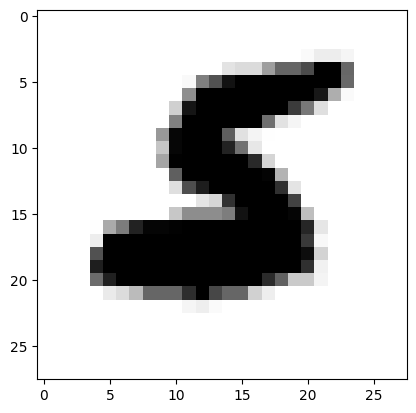

In [33]:
dataiter = iter(valloader)
images, labels = next(dataiter)
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')